In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from typing import List, Dict, Tuple

class SaliencyAnalyzer:
    """Analyzes information flow through saliency scores."""
    
    def compute_saliency_scores(
        self, attention_matrices: List[torch.Tensor], loss: torch.Tensor
    ) -> List[torch.Tensor]:
        """
        Computes saliency scores: Il(i,j) = |∑_h A_{h,l}(i,j) * ∂L/∂A_{h,l}(i,j)|
        """
        # Clone attention matrices and enable gradients
        attention_matrices = [A.clone().detach().requires_grad_(True) for A in attention_matrices]
        
        # Include attention in the loss computation graph
        combined_matrix = sum([A.sum() for A in attention_matrices])
        loss = loss + combined_matrix

        # Backpropagate loss
        loss.backward(retain_graph=True)
        
        # Compute saliency scores
        saliency_scores = []
        for A in attention_matrices:
            grad = A.grad
            if grad is None:
                raise ValueError("Gradient not computed for attention matrix. Ensure it is part of the loss computation.")
            saliency = torch.abs(A * grad)
            saliency_scores.append(saliency)
        return saliency_scores
    
    
    def compute_flow_metrics(
        self,
        saliency_scores: List[torch.Tensor],
        class_positions: torch.Tensor,
        target_position: int,
        normalize: bool = True
    ) -> Dict[str, List[float]]:
        """
        Computes S_wp, S_pq, S_ww flow metrics using the saliency scores.
        Each returned list has one value per layer.
        
        If normalize is True, applies min-max normalization across layers.
        """
        raw_metrics = {"S_wp": [], "S_pq": [], "S_ww": []}
        
        for saliency in saliency_scores:
            # Text-to-label flow (S_wp)
            wp_connections = self._get_text_to_label_connections(class_positions)
            S_wp = self._compute_average_flow(saliency, wp_connections)
            
            # Label-to-target flow (S_pq)
            pq_connections = self._get_label_to_target_connections(class_positions, target_position)
            S_pq = self._compute_average_flow(saliency, pq_connections)
            
            # Other information flow (S_ww)
            ww_connections = self._get_other_connections(class_positions, target_position, saliency.shape[-1])
            S_ww = self._compute_average_flow(saliency, ww_connections)
            
            raw_metrics["S_wp"].append(S_wp)
            raw_metrics["S_pq"].append(S_pq)
            raw_metrics["S_ww"].append(S_ww)
        
        if normalize:
            # Min-max normalization across layers for each metric
            normalized_metrics = {}
            for key, values in raw_metrics.items():
                min_val, max_val = min(values), max(values)
                if max_val > min_val:
                    normalized_metrics[key] = [(v - min_val) / (max_val - min_val) for v in values]
                else:
                    normalized_metrics[key] = [0.0 for _ in values]
            return normalized_metrics
        else:
            return raw_metrics

    def _get_text_to_label_connections(self, class_positions: torch.Tensor) -> List[Tuple[int, int]]:
        """
        Returns C_{wp} = {(p_k, j) : j < p_k}
        """
        return [(p_k, j) for p_k in class_positions for j in range(p_k)]

    def _get_label_to_target_connections(self, class_positions: torch.Tensor, target_position: int) -> List[Tuple[int, int]]:
        """
        Returns C_{pq} = {(q, p_k)}
        """
        return [(target_position, p_k) for p_k in class_positions]

    def _get_other_connections(self, class_positions: torch.Tensor, target_position: int, seq_len: int) -> List[Tuple[int, int]]:
        """
        Returns C_{ww} = {(i,j): j<i} - C_{wp} - C_{pq}
        """
        all_pairs = [(i, j) for i in range(seq_len) for j in range(i)]
        exclude = set(
            self._get_text_to_label_connections(class_positions)
            + self._get_label_to_target_connections(class_positions, target_position)
        )
        return list(set(all_pairs) - exclude)

    def _compute_average_flow(self, saliency: torch.Tensor, connections: List[Tuple[int, int]]) -> float:
        """
        Computes the average flow: sum over heads and batch, then divide by number of connections only.
        """
        if not connections:
            return 0.0
        total = 0.0
        for i, j in connections:
            # saliency: [batch, heads, seq, seq]
            # sum over batch and heads
            total += saliency[:, :, i, j].sum().item()
        # Divide by the number of connections (no head division)
        return total / len(connections)


class ICLVisualizer:
    """Visualization utilities for information flow."""
    
    @staticmethod
    def plot_information_flow(layers, Swp, Spq, Sww, title="", save_path=None):
        plt.figure(figsize=(10, 6))
        plt.plot(layers, Swp, label="S_wp", color="blue")
        plt.plot(layers, Spq, label="S_pq", color="orange")
        plt.plot(layers, Sww, label="S_ww", color="green")
        plt.xlabel("Layer")
        plt.ylabel("Normalized S")
        plt.title(title)
        plt.legend()
        plt.grid(alpha=0.3)
        if save_path:
            plt.savefig(save_path)
        plt.show()

def get_class_positions(tokenizer, input_text, labels):
    """
    Attempts to find each label in the tokenized input. If not found directly,
    tries adding a leading space to the label (common in GPT-2 tokenization).
    """
    tokenized_input = tokenizer(input_text, return_tensors="pt", add_special_tokens=False)
    input_ids = tokenized_input["input_ids"][0]

    positions = []
    for label in labels:
        # Try without leading space
        label_ids = tokenizer.encode(label, add_special_tokens=False)
        found_position = None
        for idx in range(len(input_ids) - len(label_ids) + 1):
            if torch.all(input_ids[idx: idx + len(label_ids)] == torch.tensor(label_ids)):
                found_position = idx
                break
        
        # If not found, try with leading space
        if found_position is None:
            spaced_label = " " + label if not label.startswith(" ") else label
            label_ids = tokenizer.encode(spaced_label, add_special_tokens=False)
            for idx in range(len(input_ids) - len(label_ids) + 1):
                if torch.all(input_ids[idx: idx + len(label_ids)] == torch.tensor(label_ids)):
                    found_position = idx
                    break
        
        if found_position is not None:
            positions.append(found_position)

    return positions


/Users/lihongxuan/miniconda3/envs/icl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
label_text

'sadness'

Class positions: tensor([15])


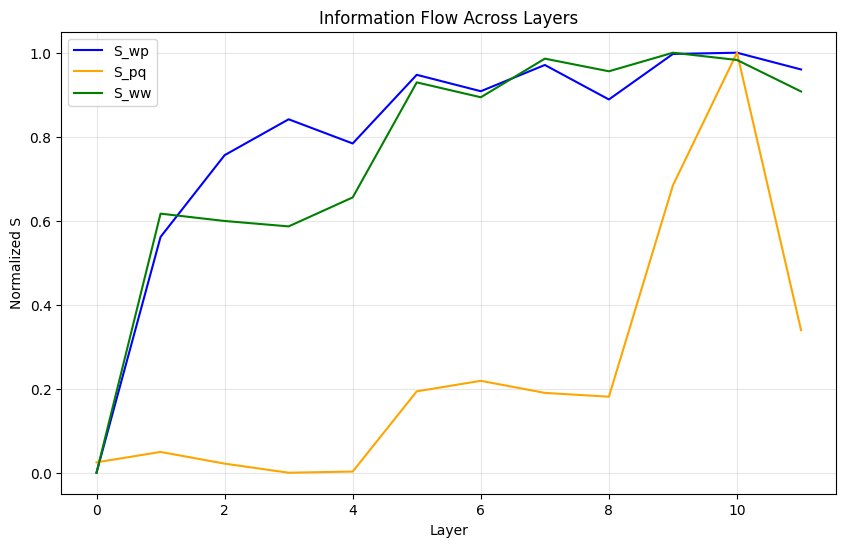

In [5]:


# ---------------------
# Running Example
# ---------------------

# 1. Load a model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
model.eval()

# 2. Create a sample prompt with labels (using the "emotion" dataset)
dataset = load_dataset("emotion", split="train[:1%]")
label_names = dataset.features["label"].names
example = dataset[0]
label_text = label_names[example["label"]]

# We create a longer prompt with multiple known labels
input_text = (
    "Sentiment analysis:\n"
    f"Review: {example['text']}\nSentiment: {label_text}\n\n"
    "Review: The movie was fantastic, I loved every moment!\nSentiment: joy\n\n"
    "Review: The waiter was rude and the food was cold.\nSentiment: anger\n\n"
    "Review: I feel so happy and energetic after this workshop.\nSentiment: joy\n\n"
    "Review: The plot was confusing and left me frustrated.\nSentiment: anger\n\n"
    "Review: The scenery was breathtaking, and I felt very pleased.\nSentiment: joy\n\n"
    "Review: The product didn't work as advertised, and I want my money back!\nSentiment: anger\n\n"
    "Review: I hated this experience.\nSentiment:"
)

# We have one demonstration of sentiment analysis with a known label, then ask for sentiment of a new review.
labels = [label_text]

# 3. Tokenize and run the model
inputs = tokenizer(input_text, return_tensors="pt")
input_ids = inputs["input_ids"]
target_position = len(input_ids[0]) - 1

with torch.no_grad():
    outputs = model(**inputs, labels=input_ids)
loss = outputs.loss
attention_matrices = outputs.attentions

# 4. Compute saliency scores
analyzer = SaliencyAnalyzer()
saliency_scores = analyzer.compute_saliency_scores(list(attention_matrices), loss)

# 5. Identify class positions (positions of label tokens)
class_positions = torch.tensor(get_class_positions(tokenizer, input_text, labels))
print("Class positions:", class_positions)

# 6. Compute and visualize flow metrics
metrics = analyzer.compute_flow_metrics(saliency_scores, class_positions, target_position, normalize=True)
S_wp = metrics["S_wp"]
S_pq = metrics["S_pq"]
S_ww = metrics["S_ww"]

layers = list(range(len(S_wp)))
ICLVisualizer.plot_information_flow(layers, S_wp, S_pq, S_ww, title="Information Flow Across Layers")



In [16]:
print(input_text)

Sentiment analysis:
Review: i didnt feel humiliated
Sentiment: sadness

Review: The movie was fantastic, I loved every moment!
Sentiment: joy

Review: The waiter was rude and the food was cold.
Sentiment: anger

Review: I feel so happy and energetic after this workshop.
Sentiment: joy

Review: The plot was confusing and left me frustrated.
Sentiment: anger

Review: The scenery was breathtaking, and I felt very pleased.
Sentiment: joy

Review: The product didn't work as advertised, and I want my money back!
Sentiment: anger

Review: I hated this experience.
Sentiment:


In [21]:
label_names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [3]:
example["label"]

3

In [10]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

# Load the "emotion" dataset
dataset = load_dataset("emotion", split="train[:2%]")
label_names = dataset.features["label"].names

# Number of demonstrations to provide
num_demos = 5

# We'll collect `num_demos` examples for demonstration, plus one more to predict
demonstration_examples = dataset.select(range(num_demos + 1))


labels = []
label_names = dataset.features["label"].names

# Build the prompt
# Start without leading spaces
input_text = "Sentiment analysis:\n"
for i in range(num_demos):
    example = demonstration_examples[i]
    text = example["text"]
    sentiment = label_names[example["label"]]
    # Add a leading space before the sentiment label
    # and ensure a space after "Sentiment:"
    spaced_sentiment = f" {sentiment}"
    input_text += f"Review: {text}\nSentiment:{spaced_sentiment}\n\n"
    labels.append(label_names[example["label"]])

# The last example (for the model to predict)
final_example = demonstration_examples[num_demos]
final_text = final_example["text"]
# Prompt the model by not providing the sentiment label this time
input_text += f"Review: {final_text}\nSentiment:"

print("Constructed input_text:\n", input_text)

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
model.eval()

inputs = tokenizer(input_text, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs, labels=inputs["input_ids"])

loss = outputs.loss
attention_matrices = outputs.attentions

# 4. Compute saliency scores
analyzer = SaliencyAnalyzer()
saliency_scores = analyzer.compute_saliency_scores(list(attention_matrices), loss)

# 5. Identify class positions (positions of label tokens)
class_positions = torch.tensor(get_class_positions(tokenizer, input_text, labels))
print("Class positions:", class_positions)

# 6. Compute and visualize flow metrics
metrics = analyzer.compute_flow_metrics(saliency_scores, class_positions, target_position, normalize=True)
S_wp = metrics["S_wp"]
S_pq = metrics["S_pq"]
S_ww = metrics["S_ww"]

layers = list(range(len(S_wp)))
ICLVisualizer.plot_information_flow(layers, S_wp, S_pq, S_ww, title="Information Flow Across Layers")



Constructed input_text:
 Sentiment analysis:
Review: i didnt feel humiliated
Sentiment: sadness

Review: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Sentiment: sadness

Review: im grabbing a minute to post i feel greedy wrong
Sentiment: anger

Review: i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Sentiment: love

Review: i am feeling grouchy
Sentiment: anger

Review: ive been feeling a little burdened lately wasnt sure why that was
Sentiment:


/Users/lihongxuan/miniconda3/envs/icl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


Class positions: tensor([15, 15, 64, 91, 64])


IndexError: index 147 is out of bounds for dimension 2 with size 129

In [9]:
labels

[0, 0, 3, 2, 3]

In [ ]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from typing import List, Dict, Tuple
import plotly.graph_objects as go
from IPython.display import display

class SaliencyAnalyzer:
    def compute_saliency_scores(self, attention_matrices: List[torch.Tensor], loss: torch.Tensor) -> List[torch.Tensor]:
        attention_matrices = [A.clone().detach().requires_grad_(True) for A in attention_matrices]
        combined_matrix = sum([A.sum() for A in attention_matrices])
        augmented_loss = loss + combined_matrix
        augmented_loss.backward(retain_graph=True)
        
        saliency_scores = []
        for A in attention_matrices:
            grad = A.grad
            if grad is None:
                raise ValueError("Gradient not computed for attention matrix")
            saliency = torch.abs(A * grad)
            saliency_scores.append(saliency)
        return saliency_scores
    
    def compute_flow_metrics(self, saliency_scores: List[torch.Tensor], 
                           class_positions: torch.Tensor,
                           target_position: int,
                           normalize: bool = True) -> Dict[str, List[float]]:
        raw_metrics = {"S_wp": [], "S_pq": [], "S_ww": []}
        
        for saliency in saliency_scores:
            wp_connections = self._get_text_to_label_connections(class_positions)
            S_wp = self._compute_average_flow(saliency, wp_connections)
            
            pq_connections = self._get_label_to_target_connections(class_positions, target_position)
            S_pq = self._compute_average_flow(saliency, pq_connections)
            
            ww_connections = self._get_other_connections(class_positions, target_position, saliency.shape[-1])
            S_ww = self._compute_average_flow(saliency, ww_connections)
            
            raw_metrics["S_wp"].append(S_wp)
            raw_metrics["S_pq"].append(S_pq)
            raw_metrics["S_ww"].append(S_ww)
        
        if normalize:
            normalized_metrics = {}
            for key, values in raw_metrics.items():
                min_val, max_val = min(values), max(values)
                if max_val > min_val:
                    normalized_metrics[key] = [(v - min_val) / (max_val - min_val) for v in values]
                else:
                    normalized_metrics[key] = [0.0 for _ in values]
            return normalized_metrics
        return raw_metrics

    def _get_text_to_label_connections(self, class_positions: torch.Tensor) -> List[Tuple[int, int]]:
        return [(p_k.item(), j) for p_k in class_positions for j in range(p_k.item())]

    def _get_label_to_target_connections(self, class_positions: torch.Tensor, target_position: int) -> List[Tuple[int, int]]:
        return [(target_position, p_k.item()) for p_k in class_positions]

    def _get_other_connections(self, class_positions: torch.Tensor, target_position: int, seq_len: int) -> List[Tuple[int, int]]:
        all_pairs = [(i, j) for i in range(seq_len) for j in range(i)]
        exclude = set(self._get_text_to_label_connections(class_positions) + 
                     self._get_label_to_target_connections(class_positions, target_position))
        return list(set(all_pairs) - exclude)

    def _compute_average_flow(self, saliency: torch.Tensor, connections: List[Tuple[int, int]]) -> float:
        if not connections:
            return 0.0
        total = 0.0
        for i, j in connections:
            if i >= saliency.shape[2] or j >= saliency.shape[3]:
                continue
            total += saliency[:, :, i, j].sum().item()
        return total / len(connections) if connections else 0.0

def generate_fancy_plot_jupyter(layers, S_wp, S_pq, S_ww):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=layers, y=S_wp,
        mode='lines+markers',
        name='demon2label',
        line=dict(color='#1f77b4'),
        marker=dict(size=8)
    ))

    fig.add_trace(go.Scatter(
        x=layers, y=S_pq,
        mode='lines+markers',
        name='label2target',
        line=dict(color='#d62728'),
        marker=dict(size=8)
    ))

    fig.add_trace(go.Scatter(
        x=layers, y=S_ww,
        mode='lines+markers',
        name='demon2demon',
        line=dict(color='#2ca02c'),
        marker=dict(size=8)
    ))

    fig.update_layout(
        title='Information Flow Across Layers',
        xaxis_title='Layer',
        yaxis_title='Normalized S',
        legend=dict(x=0.1, y=1.1, orientation='h'),
        margin=dict(l=50, r=50, t=80, b=50)
    )

    fig.show()
def get_class_positions(tokenizer, input_text, labels):
    tokenized_input = tokenizer(input_text, return_tensors="pt", add_special_tokens=False)
    input_ids = tokenized_input["input_ids"][0]
    positions = []
    
    for label in labels:
        label_ids = tokenizer.encode(label, add_special_tokens=False)
        found_position = None
        
        for idx in range(len(input_ids) - len(label_ids) + 1):
            if torch.all(input_ids[idx: idx + len(label_ids)] == torch.tensor(label_ids)):
                found_position = idx
                break
        
        if found_position is None:
            spaced_label = " " + label if not label.startswith(" ") else label
            label_ids = tokenizer.encode(spaced_label, add_special_tokens=False)
            for idx in range(len(input_ids) - len(label_ids) + 1):
                if torch.all(input_ids[idx: idx + len(label_ids)] == torch.tensor(label_ids)):
                    found_position = idx
                    break
        
        if found_position is not None:
            positions.append(found_position)
        else:
            print(f"Warning: Label '{label}' not found in input text.")
    
    return positions

def find_last_sentiment_position(tokenizer, input_ids):
    sentiment_token_ids = tokenizer.encode("Demonstration:", add_special_tokens=False)
    sentiment_length = len(sentiment_token_ids)
    positions = []
    
    for i in range(len(input_ids) - sentiment_length + 1):
        if torch.all(input_ids[i:i+sentiment_length] == torch.tensor(sentiment_token_ids)):
            positions.append(i)
    
    if not positions:
        raise ValueError("No 'Sentiment:' token found in input_ids.")
    
    last_sentiment_start = positions[-1]
    target_position = last_sentiment_start + sentiment_length
    return min(target_position, len(input_ids) - 1)

def main():
    dataset = load_dataset("emotion", split="train[:2%]")
    num_demos = 5
    demonstration_examples = dataset.select(range(num_demos + 1))
    labels = []
    label_names = dataset.features["label"].names
    input_text = ""
    for i in range(num_demos):
        example = demonstration_examples[i]
        text = example["text"]
        sentiment = label_names[example["label"]]
        spaced_sentiment = f" {sentiment}"
        input_text += f"Demonstration: {text}\nLabel:{spaced_sentiment}\n\n"
        labels.append(label_names[example["label"]])
    
    final_example = demonstration_examples[num_demos]
    final_text = final_example["text"]
    input_text += f"Demonstration: {final_text}\nLabel:"


    
    model_name = "gpt2"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
    model.eval()
    
    inputs = tokenizer(input_text, return_tensors="pt")
    input_ids = inputs["input_ids"][0]
    target_position = find_last_sentiment_position(tokenizer, input_ids)
    
    model.train()
    outputs = model(**inputs, labels=inputs["input_ids"])
    
    analyzer = SaliencyAnalyzer()
    saliency_scores = analyzer.compute_saliency_scores(list(outputs.attentions), outputs.loss)
    
    class_positions = torch.tensor(get_class_positions(tokenizer, input_text, labels))
    metrics = analyzer.compute_flow_metrics(saliency_scores, class_positions, target_position, normalize=True)
    
    layers = list(range(1, len(metrics["S_wp"]) + 1))
    generate_fancy_plot_jupyter(layers, metrics["S_wp"], metrics["S_pq"], metrics["S_ww"])

if __name__ == "__main__":
    main()

In [7]:
dataset = load_dataset("emotion", split="train[:2%]")
num_demos = 5
demonstration_examples = dataset.select(range(num_demos + 1))
labels = []
label_names = dataset.features["label"].names